<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.patches import Polygon
from matplotlib import animation
import seaborn as sns
import scipy as sp
from scipy import signal
from scipy.interpolate import griddata
from datetime import timedelta, datetime
from IPython.display import HTML

In [3]:
def mask_outside_polygon(poly_verts, ax=None):
    """
    Plots a mask on the specified axis ("ax", defaults to plt.gca()) such that
    all areas outside of the polygon specified by "poly_verts" are masked.  

    "poly_verts" must be a list of tuples of the verticies in the polygon in
    counter-clockwise order.

    Returns the matplotlib.patches.PathPatch instance plotted on the figure.
    """
    import matplotlib.patches as mpatches
    import matplotlib.path as mpath

    if ax is None:
        ax = plt.gca()

    # Get current plot limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Verticies of the plot boundaries in clockwise order
    bound_verts = [(xlim[0], ylim[0]), (xlim[0], ylim[1]), 
                   (xlim[1], ylim[1]), (xlim[1], ylim[0]), 
                   (xlim[0], ylim[0])]

    # A series of codes (1 and 2) to tell matplotlib whether to draw a line or 
    # move the "pen" (So that there's no connecting line)
    bound_codes = [mpath.Path.MOVETO] + (len(bound_verts) - 1) * [mpath.Path.LINETO]
    poly_codes = [mpath.Path.MOVETO] + (len(poly_verts) - 1) * [mpath.Path.LINETO]

    # Plot the masking patch
    path = mpath.Path(bound_verts + poly_verts, bound_codes + poly_codes)
    patch = mpatches.PathPatch(path, facecolor='white', edgecolor='none')
    patch = ax.add_patch(patch)

    # Reset the plot limits to their original extents
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return patch

# Choose the Year for Analysis

In [4]:
year = '2017'

# Importing Data

## Get Station Number as a Function of Longitudes and Latitudes

In [5]:
lon_and_lat = np.genfromtxt('AllStations_temperature_h_2017.dat', delimiter=" ", max_rows=2)
longitudes = lon_and_lat[0][~np.isnan(lon_and_lat[0])]
latitudes = lon_and_lat[1][~np.isnan(lon_and_lat[1])]

indices = list(zip(np.array(longitudes), np.array(latitudes)))
indices.insert(0, "time")

Dictionary that provides the mapping:

In [6]:
location_to_station_num = dict(zip(indices[1::], np.arange(0,37)))

## Import Data

In [7]:
winter_df_2017 = pd.read_pickle('Dataframes/winter_2017.pkl')
summer_df_2017 = pd.read_pickle('Dataframes/summer_2017.pkl')
winter_df_2016 = pd.read_pickle('Dataframes/winter_2016.pkl')
summer_df_2016 = pd.read_pickle('Dataframes/summer_2016.pkl')
winter_df_2015 = pd.read_pickle('Dataframes/winter_2015.pkl')
summer_df_2015 = pd.read_pickle('Dataframes/summer_2015.pkl')
winter_df_2014 = pd.read_pickle('Dataframes/winter_2014.pkl')
summer_df_2014 = pd.read_pickle('Dataframes/summer_2014.pkl')
winter_df_2013 = pd.read_pickle('Dataframes/winter_2013.pkl')
summer_df_2013 = pd.read_pickle('Dataframes/summer_2013.pkl')
winter_df_2012 = pd.read_pickle('Dataframes/winter_2012.pkl')
summer_df_2012 = pd.read_pickle('Dataframes/summer_2012.pkl')
winter_df_2011 = pd.read_pickle('Dataframes/winter_2011.pkl')
summer_df_2011 = pd.read_pickle('Dataframes/summer_2011.pkl')
winter_df_2010 = pd.read_pickle('Dataframes/winter_2010.pkl')
summer_df_2010 = pd.read_pickle('Dataframes/summer_2010.pkl')

winter_dfs = [winter_df_2010, winter_df_2011, winter_df_2012, winter_df_2013,
             winter_df_2014, winter_df_2015, winter_df_2016, winter_df_2017]
summer_dfs = [summer_df_2010, summer_df_2011, summer_df_2012, summer_df_2013, 
             summer_df_2014, summer_df_2015, summer_df_2016, summer_df_2017]

In [8]:
winter_df = pd.read_pickle('Dataframes/winter_'+year+'.pkl')
summer_df = pd.read_pickle('Dataframes/summer_'+year+'.pkl')

In [9]:
winter_stations = np.array([location_to_station_num[winter_df.columns[i]] for i in range(len(winter_df.columns))])
summer_stations = np.array([location_to_station_num[summer_df.columns[i]] for i in range(len(summer_df.columns))])

Check to make sure data is okay

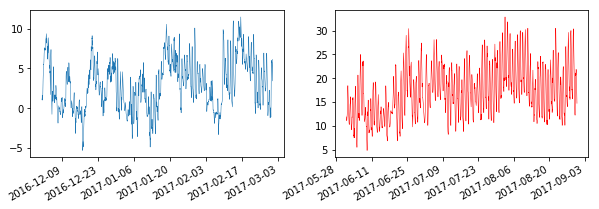

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))

winter_df.iloc[:,0].plot(ax = ax[0], lw=0.5)
summer_df.iloc[:,0].plot(ax = ax[1], color='r', lw=0.5)

plt.show()

In [11]:
lons_and_lats = np.array(winter_df.columns)
winter_lons = np.array(list(zip(*lons_and_lats))[0])
winter_lats = np.array(list(zip(*lons_and_lats))[1])

lons_and_lats = np.array(summer_df.columns)
summer_lons = np.array(list(zip(*lons_and_lats))[0])
summer_lats = np.array(list(zip(*lons_and_lats))[1])

## Coastline Map and Island Mapping

Get the values for the coastline. The init arrays are used for when we draw a polygon over the water (otherwise we'd draw a polygon over the island).

In [12]:
coast_array = pd.read_csv('Coast.dat.txt', sep='\s+', names=['lon', 'lat'])
coast_lon_init = np.array([236, 236.8, 236.8])
coast_lat_init = np.array([48.3, 48.3, 48.999])

Get array of coastline.

In [13]:
coast_lon = coast_array['lon'].values+360
coast_lat = coast_array['lat'].values

Use to draw polygon of water

In [14]:
water_poly_lon = np.concatenate((coast_lon_init, coast_lon))
water_poly_lat = np.concatenate((coast_lat_init, coast_lat))

Lon and Lat limits for the area we are concerned with

# Get Eigenmodes

These are the functions used.

In [15]:
def get_alpha(df, mode):
    alpha = []
    for index, row in df.iterrows():
        alpha.append(sum(row.values*mode))
    
    return np.array(alpha)

In [16]:
def get_prin_comp(df, interp = 'linear'):
    
    # Get Longitude and latitude of Station
    lons_and_lats = np.array(winter_df.columns)
    lons = np.array(list(zip(*lons_and_lats))[0])
    lats = np.array(list(zip(*lons_and_lats))[1])
    
    # Make a meshgrid
    Nx = 100
    Ny = 50
    xx_grid = np.linspace(min(lons), max(lons), Nx)
    yy_grid = np.linspace(min(lats), max(lats), Ny)
    X_grid, Y_grid = np.meshgrid(xx_grid, yy_grid)
    
    # Get Covariance Matrix with Eigenmodes and Eigenvectors
    C = df.cov()
    eig_vals, eig_vecs = np.linalg.eigh(C)
    eig_vals_norm_wint = eig_vals/sum(eig_vals)
    
    # Get the Modes
    points = np.array(list(zip(winter_lons, winter_lats)))
    mode1 = eig_vecs[:,-1]
    mode2 = eig_vecs[:,-2]
    mode3 = eig_vecs[:,-3]
    mode4 = eig_vecs[:,-4]
    
    # Get Principal Components
    a1 = get_alpha(df, mode1) 
    a2 = get_alpha(df, mode2) 
    a3 = get_alpha(df, mode3) 
    a4 = get_alpha(df, mode4) 
    
    return a1, a2, a3, a4

## Finding Principle Components and Temperature Stuff

Our eigenvectors are known as orthogonal eigenmodes where $\vec{e}_i \cdot \vec{e}_j = \delta_{ij}$

Our function can be represented as 

$$\vec{x}(t) = \sum_i \alpha_i(t) \vec{e}_i $$

where $\vec{x}$ is a vector that contains the temperature of all our stations. To find $\alpha_k(t)$ (which will be a function of time) we use

$$\vec{x}(t) \cdot \vec{e}_k =\left(\sum_i \alpha_i(t) \vec{e}_i \right) \cdot \vec{e}_k =\alpha_k(t) $$

which follows from the orthonormality above. Once we have $\alpha_k(t)$, we can plot

$$\alpha_k(t) \vec{e}_k $$

instead of just plotting $\vec{e}_k$. Since $\alpha_k(t)$ is a function of time, we may as well take the mean value (if $\alpha$ is fairly constant).

## Winter

In [17]:
times_wint = np.array(winter_df_2016.index)
w1, w2, w3, w4 = get_prin_comp(winter_df_2016)

times_sum = np.array(summer_df_2016.index)
s1, s2, s3, s4 = get_prin_comp(summer_df_2016)

Plot

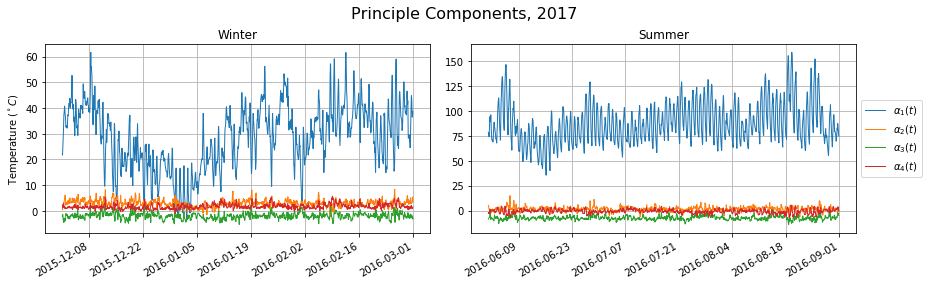

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].plot(times_wint, w1, label=r'$\alpha_1(t)$', lw=1)
ax[0].plot(times_wint, w2, label=r'$\alpha_2(t)$', lw=1)
ax[0].plot(times_wint, w3, label=r'$\alpha_3(t)$', lw=1)
ax[0].plot(times_wint, w4, label=r'$\alpha_4(t)$', lw=1)

ax[0].set_title('Winter')
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].grid()

ax[1].plot(times_sum, s1, label=r'$\alpha_1(t)$', lw=1)
ax[1].plot(times_sum, s2, label=r'$\alpha_2(t)$', lw=1)
ax[1].plot(times_sum, s3, label=r'$\alpha_3(t)$', lw=1)
ax[1].plot(times_sum, s4, label=r'$\alpha_4(t)$', lw=1)

ax[1].set_title('Summer')
ax[1].grid()

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.autofmt_xdate()
fig.suptitle('Principle Components, 2017', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

plt.savefig('plots/wintsum_prin_comps_'+year+'.png', dpi=200)
plt.show()

# Do Fourier Analysis On Principal Components

In [19]:
def plot_freq_modes(w, ax):
    NT = len(w)
    N = 2**8

    x = w - np.mean(w)
    f, X = sp.signal.welch(w, fs=1/3600, window='hanning', nperseg=N, detrend=False, noverlap = N / 2)
    ax.loglog(f, X, label='201'+str(i), lw=0.5)

## Summer Modes

In [20]:
sum_mode1s = np.array([get_prin_comp(df)[0] for df in summer_dfs])
sum_mode2s = np.array([get_prin_comp(df)[1] for df in summer_dfs])
sum_mode3s = np.array([get_prin_comp(df)[2] for df in summer_dfs])
sum_mode4s = np.array([get_prin_comp(df)[3] for df in summer_dfs])

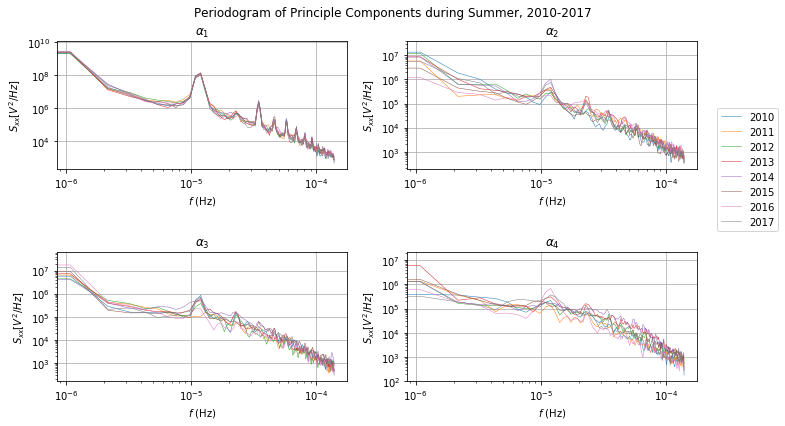

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(11,6))

for (i, w) in enumerate(sum_mode1s):
    plot_freq_modes(w, ax[0][0])
for (i, w) in enumerate(sum_mode2s):
    plot_freq_modes(w, ax[0][1])
for (i, w) in enumerate(sum_mode3s):
    plot_freq_modes(w, ax[1][0])
for (i, w) in enumerate(sum_mode4s):
    plot_freq_modes(w, ax[1][1])

ax[0][1].legend(loc='center left', bbox_to_anchor=(1.05, 0))

ax[0][0].set_title(r'$\alpha_1$')
ax[0][1].set_title(r'$\alpha_2$')
ax[1][0].set_title(r'$\alpha_3$')
ax[1][1].set_title(r'$\alpha_4$')

[a.set_ylabel('$S_{xx}[V^2/Hz]$') for a in ax.ravel()]
[a.set_xlabel('$f$ (Hz)') for a in ax.ravel()]
[a.grid() for a in ax.ravel()]

fig.suptitle('Periodogram of Principle Components during Summer, 2010-2017')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.savefig('plots/prin_com_sum_periodogram.png', dpi=200)

## Winter Modes

In [22]:
win_mode1s = np.array([get_prin_comp(df)[0] for df in winter_dfs])
win_mode2s = np.array([get_prin_comp(df)[1] for df in winter_dfs])
win_mode3s = np.array([get_prin_comp(df)[2] for df in winter_dfs])
win_mode4s = np.array([get_prin_comp(df)[3] for df in winter_dfs])

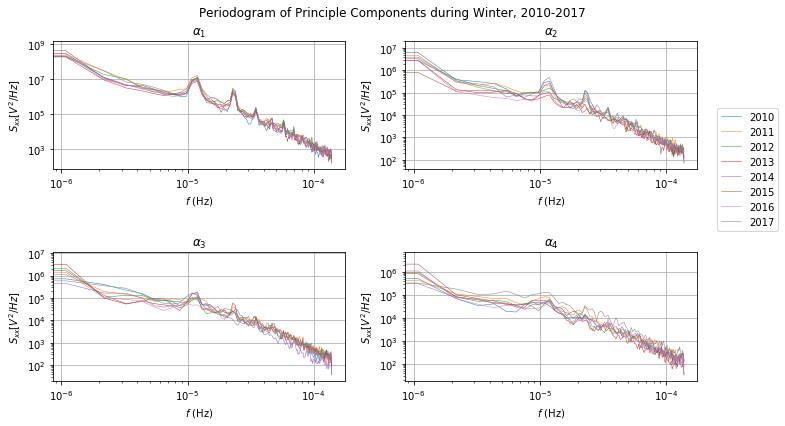

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(11,6))

for (i, w) in enumerate(win_mode1s):
    plot_freq_modes(w, ax[0][0])
for (i, w) in enumerate(win_mode2s):
    plot_freq_modes(w, ax[0][1])
for (i, w) in enumerate(win_mode3s):
    plot_freq_modes(w, ax[1][0])
for (i, w) in enumerate(win_mode4s):
    plot_freq_modes(w, ax[1][1])

ax[0][1].legend(loc='center left', bbox_to_anchor=(1.05, 0))

ax[0][0].set_title(r'$\alpha_1$')
ax[0][1].set_title(r'$\alpha_2$')
ax[1][0].set_title(r'$\alpha_3$')
ax[1][1].set_title(r'$\alpha_4$')

[a.set_ylabel('$S_{xx}[V^2/Hz]$') for a in ax.ravel()]
[a.set_xlabel('$f$ (Hz)') for a in ax.ravel()]
[a.grid() for a in ax.ravel()]

fig.suptitle('Periodogram of Principle Components during Winter, 2010-2017')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.savefig('plots/prin_com_win_periodogram.png', dpi=200)